# Matching Lambda_OU and Lambda_LogOU

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Functions for SIS White, OU and LogOU

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def PCS_SDE_nd(h, N, X0, f, g):
    """
    Predictor-corrector scheme of Cao, Zhaong, and Karniadakis, SIAM J. SCI. COMPUT, 2015
    f = drift term, g = diffusion term
    
    Parameters:
    h (float): time step size
    N (int): number of steps
    X0 (numpy.ndarray): initial condition
    f (function): drift function
    g (function): diffusion function
    
    Returns:
    numpy.ndarray: simulated path
    """
    nd = len(X0)
    X = np.nan * np.ones((nd, N + 1))
    X[:, 0] = X0
    dW = np.sqrt(h) * np.random.randn(nd, N + 1)

    for j in range(N):
        X_bar = X[:, j] + h * f(X[:, j]) + g(X[:, j]) * dW[:, j]
        
        X[:, j + 1] = (X[:, j] + (h / 2) * (f(X[:, j]) + f(X_bar)) + 
                       (1 / 2) * ((g(X[:, j]) + g(X_bar)) * dW[:, j]))

    return X

def SIS_White(rel_int=0.5, R0=1.5, lamb=0.1, time_step=0.01, NN=10000, N=50, X0s=np.array([0.9]), plotting=True):

    gamma = lamb / R0
    sigma = np.sqrt(rel_int * lamb)

    def myDrift(X):
        return np.array([lamb * X * (1 - X) - gamma*X])

    def myDiffusion(X):
        return np.array([sigma * X * (1 - X)])
    
    Ys = []

    for _ in range(N):
        Xs = PCS_SDE_nd(time_step, NN, X0s, myDrift, myDiffusion)
        Ys.append(Xs[0, :])

    if plotting:
        for y in Ys:
            plt.plot(y)
        plt.title('SIS White Noise')
        plt.show()

    return Ys


def SIS_OU(rel_int=0.5, R0=1.5, lamb=0.1, time_step=0.01, NN=10000, N=50, 
           X0s=np.array([0.0, 0.9]), tau=0.2, plotting=True):
    """
    SIS model with Ornstein-Uhlenbeck (OU) noise.
    """
    gamma = lamb / R0
    sigma_OU = np.sqrt(rel_int * lamb)

    def myDrift(X):
        return np.array([
            - (1 / tau) * X[0],  
            (lamb + sigma_OU * X[0]) * X[1] * (1 - X[1]) - gamma * X[1]
            # (lamb + X[0]) * X[1] * (1 - X[1]) - gamma * X[1]
        ])

    def myDiffusion(X):
        return np.array([
            1 / tau, 0
        ])

    noise_trajectories = []
    Ys = []

    for _ in range(N):
        Xs = PCS_SDE_nd(time_step, NN, X0s, myDrift, myDiffusion)
        Ys.append(Xs[1, :])
        noise_trajectories.append(lamb + sigma_OU * Xs[0, :])  

    if plotting:
        for y in Ys:
            plt.plot(y)
        plt.title('SIS OU Noise')
        plt.show()

    return Ys, noise_trajectories


def SIS_LogOU(rel_int=0.5, R0=1.5, lamb=0.1, time_step=0.01, NN=10000, N=50, 
              X0s=np.array([0.0, 0.9]), tau=0.2, plotting=True):
    """
    SIS model with lognormal Ornstein-Uhlenbeck (Log-OU) noise, ensuring same variance and correlation time as OU.
    """
    gamma = lamb / R0
    sigma_OU = np.sqrt(rel_int * lamb) 
    print(sigma_OU**2 / (2*tau))

    sigma_logOU, tau = compute_lognormal_ou_params(sigma_OU, tau)
    print(sigma_logOU, tau)
    
    def myDrift(X):
        return np.array([
            - (1 / tau) * X[0],
            (lamb * np.exp(sigma_logOU * X[0])) * X[1] * (1 - X[1]) - gamma * X[1]
            # (lamb * np.exp(X[0])) * X[1] * (1 - X[1]) - gamma * X[1]
        ])

    def myDiffusion(X):
        return np.array([
            1 / tau, 0
        ])

    noise_trajectories = []
    Ys = []

    for _ in range(N):
        Xs = PCS_SDE_nd(time_step, NN, X0s, myDrift, myDiffusion)
        Ys.append(Xs[1, :])
        noise_trajectories.append((lamb * np.exp(sigma_logOU * Xs[0, :])))

    if plotting:
        for y in Ys:
            plt.plot(y)
        plt.title('SIS LogOU Noise')
        plt.show()

    return Ys, noise_trajectories


In [6]:
def lambda_trajectory_white_noise(rel_int=0.5, lamb=0.1, NN=10000, N=50):
    sigma = np.sqrt(rel_int * lamb)
    def lambda_t(j):
        return lamb + sigma * np.random.randn()

    noise_trajectories = []

    for _ in range(N):
        noise_trajectories.append([lambda_t(j) for j in range(NN)])

    return noise_trajectories

# Getting all trajectories

In [112]:
# Set parameters
skip = 5000

NN = 10000 # Number of time steps
N = 500 # Number of trajectories
time_step = 0.01 # Time step size
rel_int = 1.0 # 2.0
rel_corr_time = 0.5
R0 = 1.4
lamb = 1.4

time = np.arange(0, NN * time_step, time_step)[skip-1:]

gamma = lamb / R0
eta = 1 / (lamb - gamma)
tau = eta * rel_corr_time

print('R0 = ', R0)
print('lambda = ', lamb)
print('gamma = ', gamma)
print('characteristic time scale = ', eta)
print('tau = ', tau)

R0 =  1.4
lambda =  1.4
gamma =  1.0
characteristic time scale =  2.5000000000000004
tau =  1.2500000000000002


In [113]:
from scipy.special import expi

def compute_lognormal_ou_params(D, s):

    gamma_euler = 0.57721566490153286060  # Euler-Mascheroni constant

    V_lnOU = D**2 / (2*s)
    den = lamb**2 * (1 + np.sqrt(1 + (4*V_lnOU / lamb**2)))
    sigma2_by_2tau = np.log(1 + 2*V_lnOU/den)

    tau = s * (np.exp(sigma2_by_2tau) - 1) / (expi(sigma2_by_2tau) - np.log(sigma2_by_2tau) - gamma_euler)
    sigma = np.sqrt(sigma2_by_2tau * 2 * tau)

    return sigma, tau

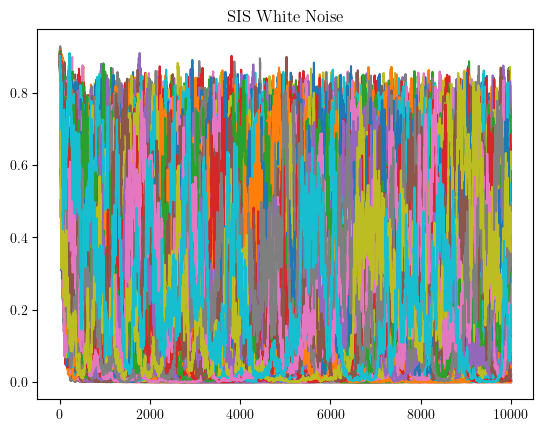

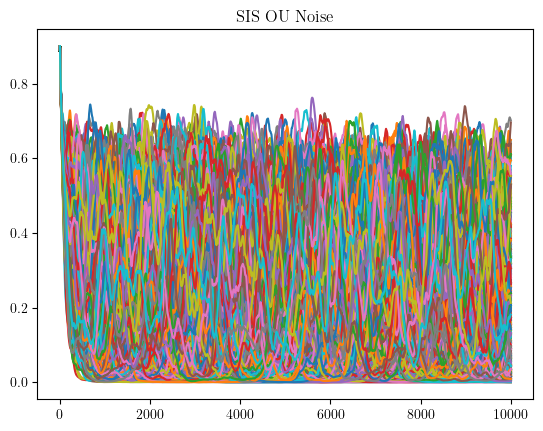

0.5599999999999998
0.7414600619544818 1.3178833377513501


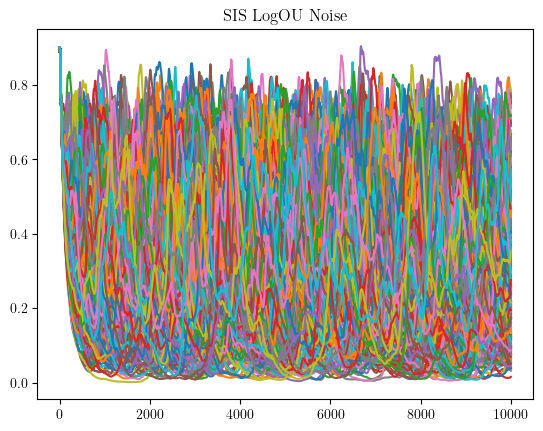

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# Run simulations to extract noise
white, noise_white = SIS_White(rel_int, R0, lamb, time_step, NN, N=N, plotting=True), lambda_trajectory_white_noise(rel_int, lamb, NN, N)
ou, noise_OU = SIS_OU(rel_int, R0, lamb, time_step, NN, N=N, tau=tau, plotting=True)
logou, noise_logOU = SIS_LogOU(rel_int, R0, lamb, time_step, NN, N=N, tau=tau, plotting=True)

### Keeping only steady state

In [115]:
white = np.array(white)[:, skip:]
ou = np.array(ou)[:, skip:]
logou = np.array(logou)[:, skip:]

In [116]:
noise_white = np.array(noise_white)[:, skip-1:]
noise_OU = np.array(noise_OU)[:, skip:]
noise_logOU = np.array(noise_logOU)[:, skip:]

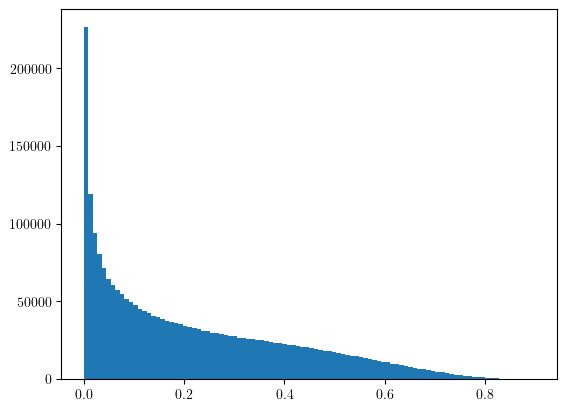

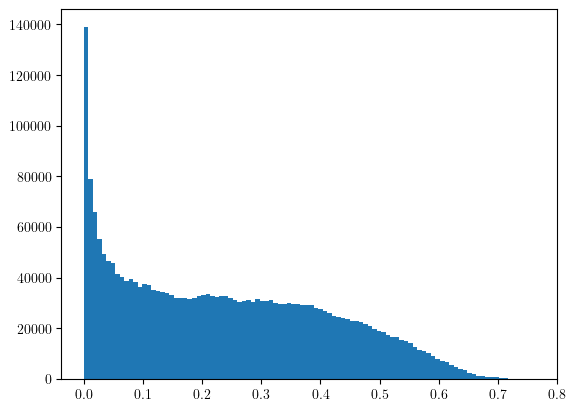

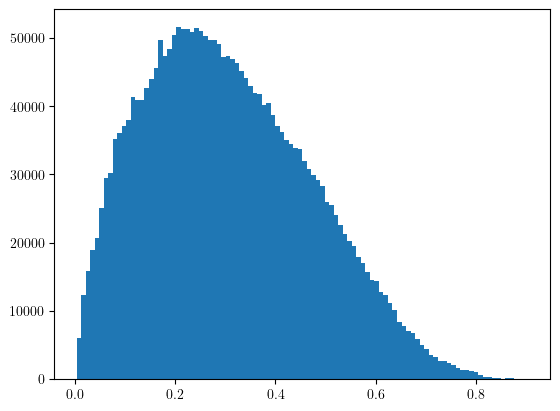

In [117]:
plt.hist(np.concatenate(white), bins=100)
plt.show()
plt.hist(np.concatenate(ou), bins=100)
plt.show()
plt.hist(np.concatenate(logou), bins=100)
plt.show()

# Plotting noise trajectories

In [118]:
time = time-time[0]

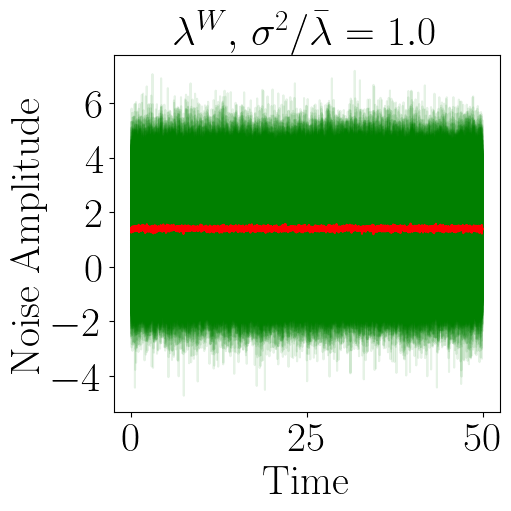

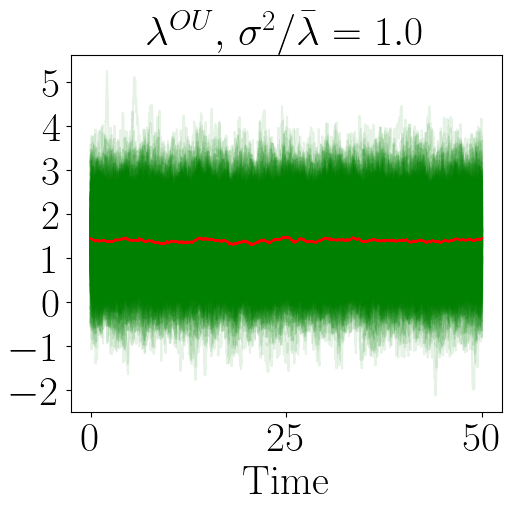

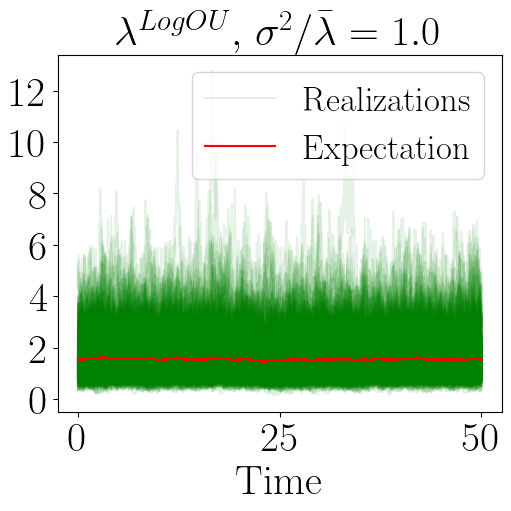

In [119]:
average_time_series = np.mean(noise_white, axis=0)

fig = plt.figure(figsize=(5, 5), constrained_layout=True)

for _ in range(N):
    if _ == 0:
        plt.plot(time, noise_white[_], 'g', alpha=0.1, label='Realizations')
    else:
        plt.plot(time, noise_white[_], 'g', alpha=0.1)

plt.plot(time, average_time_series, 'r', label='Expectation')
# plt.legend(loc='upper left', fontsize=25)
# plt.title('White Noise', fontsize=30)
plt.xticks([0, 25, 50], fontsize=30)
plt.title(r'$\lambda^{W}, \space$ $\sigma^2 / \bar{\lambda} =$' + f' ${rel_int}$', fontsize=30)
plt.xlabel(r'Time', fontsize=30)
plt.ylabel(r'Noise Amplitude', fontsize=30)
plt.yticks(fontsize=30)

plt.savefig(f'White_noise_{rel_int}.png', dpi=150)#, bbox_inches='tight')
plt.show()

average_time_series = np.mean(noise_OU, axis=0)

fig = plt.figure(figsize=(5, 5), constrained_layout=True)

for _ in range(N):
    if _ == 0:
        plt.plot(time, noise_OU[_], 'g', alpha=0.1, label='Realizations')
    else:
        plt.plot(time, noise_OU[_], 'g', alpha=0.1)

plt.plot(time, average_time_series, 'r', label='Expectation')
# plt.legend(loc='upper left', fontsize=25)
# plt.title('OU Noise', fontsize=30)
plt.xticks([0, 25, 50], fontsize=30)
plt.title(r'$\lambda^{OU}, \space$ $\sigma^2 / \bar{\lambda} =$' + f' ${rel_int}$', fontsize=30)
plt.xlabel(r'Time', fontsize=30)
# plt.ylabel(r'Noise Amplitude', fontsize=30)
plt.yticks(fontsize=30)

plt.savefig(f'OU_noise_{rel_int}.png', dpi=150)#, bbox_inches='tight')
plt.show()


average_time_series = np.mean(noise_logOU, axis=0)

fig = plt.figure(figsize=(5, 5), constrained_layout=True)

for _ in range(N):
    if _ == 0:
        plt.plot(time, noise_logOU[_], 'g', alpha=0.1, label='Realizations')
    else:
        plt.plot(time, noise_logOU[_], 'g', alpha=0.1)

plt.plot(time, average_time_series, 'r', label='Expectation')
plt.legend(loc="upper right", bbox_to_anchor=(1, 1), fontsize=25)
# plt.title('LogOU Noise', fontsize=30)
plt.xticks([0, 25, 50], fontsize=30)
plt.title(r'$\lambda^{LogOU}, \space$ $\sigma^2 / \bar{\lambda} =$' + f' ${rel_int}$', fontsize=30)
plt.xlabel(r'Time', fontsize=30)
# plt.ylabel(r'Noise Amplitude', fontsize=30)
plt.yticks(fontsize=30)

plt.savefig(f'LogOU_noise_{rel_int}.png', dpi=150)#, bbox_inches='tight')
plt.show()



# Compute ACF

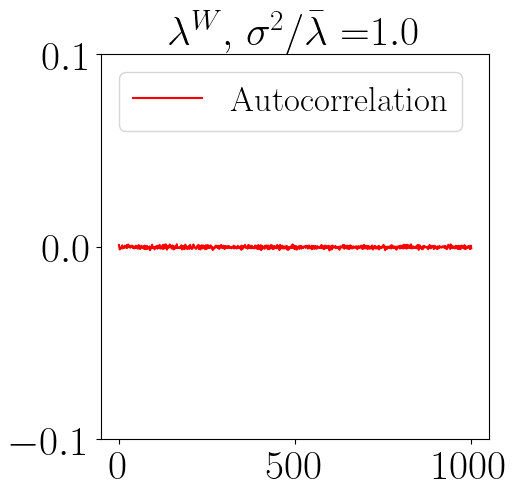

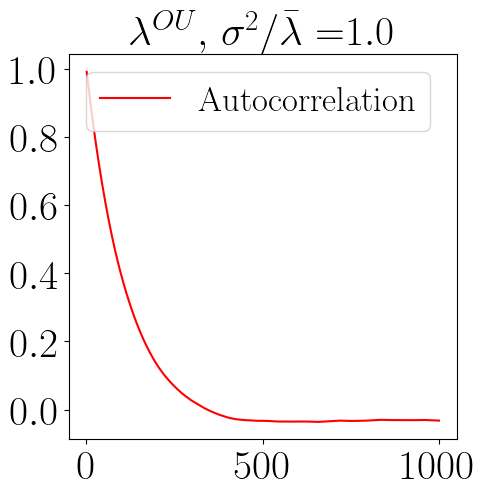

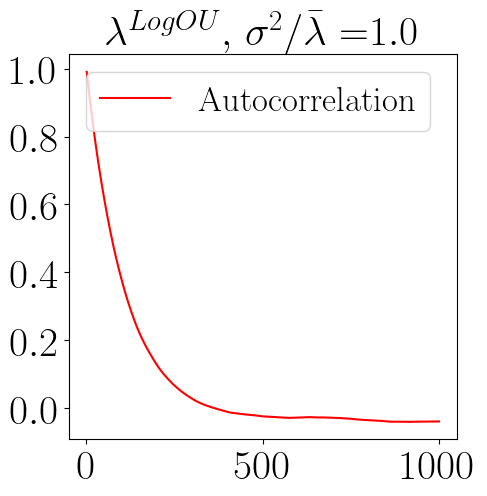

In [120]:
from statsmodels.tsa.stattools import acf

def compute_expected_acf(trajectories, max_lag=100):
    """
    Compute the expected autocorrelation function (ACF) across multiple trajectories.

    Parameters:
    - trajectories (list of np.ndarray): List of noise trajectories from SIS_LogOU.
    - max_lag (int): Maximum lag for computing the ACF.

    Returns:
    - lags (np.ndarray): Array of lag values.
    - expected_acf (np.ndarray): Expected ACF averaged over all trajectories.
    """
    num_traj = len(trajectories)
    acf_values = []

    for traj in trajectories:
        acf_values.append(acf(traj, nlags=max_lag, fft=False))

    expected_acf = np.mean(acf_values, axis=0)

    return expected_acf

# Compute autocorrelations (using first trajectory)
lag = 1000
acf_white = compute_expected_acf(noise_white, max_lag=lag)
acf_OU = compute_expected_acf(noise_OU, max_lag=lag)
acf_logOU = compute_expected_acf(noise_logOU, max_lag=lag)

# # Plot autocorrelation functions
# plt.figure(figsize=(10, 5))
# plt.plot(acf_white[:], label='White Noise', linestyle='dotted')
# plt.plot(acf_OU[:], label='OU Noise', linestyle='dashed')
# plt.plot(acf_logOU[:], label='Lognormal OU Noise', linestyle='solid')
# plt.xlabel('Lag')
# plt.ylabel('Autocorrelation')
# plt.title('Autocorrelation of Noise Types')
# plt.legend()
# plt.show()


fig = plt.figure(figsize=(5, 5))
plt.plot(range(1, lag+1), acf_white[1:], 'r', label='Autocorrelation')
# plt.hlines(0, 0, lag, color='black', linestyle='--')
plt.legend(loc='upper left', fontsize=25)
plt.title(r'$\lambda^{W}, \space$ $\sigma^2 / \bar{\lambda} = $' + f'${rel_int}$', fontsize=30)
# plt.xlabel('Lag')
# plt.ylabel('Autocorrelation')
plt.grid(False)
plt.xticks([0, lag/2, lag], fontsize=30)
plt.yticks(fontsize=30)
plt.ylim([-0.1, 0.1])
plt.yticks([-0.1, 0, 0.1])
# plt.savefig(f'White_autocor_{rel_int}.png', dpi=150)#, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.plot(range(1, lag+1), acf_OU[1:], 'r', label='Autocorrelation')
# plt.hlines(0, 0, lag, color='black', linestyle='--')
plt.legend(loc='upper left', fontsize=25)
plt.title(r'$\lambda^{OU}, \space$ $\sigma^2 / \bar{\lambda} = $' + f'${rel_int}$', fontsize=30)
# plt.xlabel('Lag')
# plt.ylabel('Autocorrelation')
plt.grid(False)
plt.xticks([0, lag/2, lag], fontsize=30)
plt.yticks(fontsize=30)
# plt.ylim([-0.1, 0.1])
# plt.yticks([-0.1, 0, 0.1])
# plt.savefig(f'OU_autocor_{rel_int}.png', dpi=150)#, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.plot(range(1, lag+1), acf_logOU[1:], 'r', label='Autocorrelation')
# plt.hlines(0, 0, lag, color='black', linestyle='--')
plt.legend(loc='upper left', fontsize=25)
plt.title(r'$\lambda^{LogOU}, \space$ $\sigma^2 / \bar{\lambda} = $' + f'${rel_int}$', fontsize=30)
# plt.xlabel('Lag')
# plt.ylabel('Autocorrelation')
plt.grid(False)
plt.xticks([0, lag/2, lag], fontsize=30)
plt.yticks(fontsize=30)
# plt.ylim([-0.1, 0.1])
# plt.yticks([-0.1, 0, 0.1])
# plt.savefig(f'LogOU_autocor_{rel_int}.png', dpi=150)#, bbox_inches='tight')
plt.show()

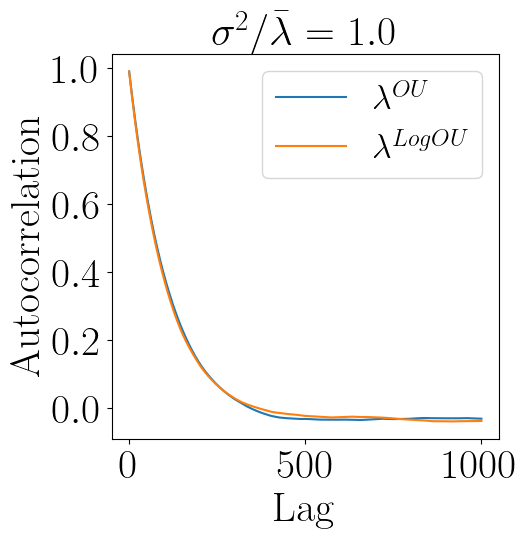

In [121]:
fig = plt.figure(figsize=(5, 5))
plt.plot(range(1, lag+1), acf_OU[1:], label=r'$\lambda^{OU}$')
plt.plot(range(1, lag+1), acf_logOU[1:], label=r'$\lambda^{LogOU}$')
plt.legend(loc='upper right', fontsize=25)
plt.title(r'$\sigma^2 / \bar{\lambda} =$' + f' ${rel_int}$', fontsize=30)
plt.xlabel('Lag', fontsize=30)
plt.ylabel('Autocorrelation', fontsize=30)
plt.grid(False)
plt.xticks([0, lag/2, lag], fontsize=30)
plt.yticks(fontsize=30)
# plt.ylim([-0.1, 0.1])
# plt.yticks([-0.1, 0, 0.1])
plt.savefig(f'Autocorrelation_{rel_int}.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot Distribution of Lambda

-4.735509039706805 7.19252939424236
5.029159046703301e-06 0.3344038724924426


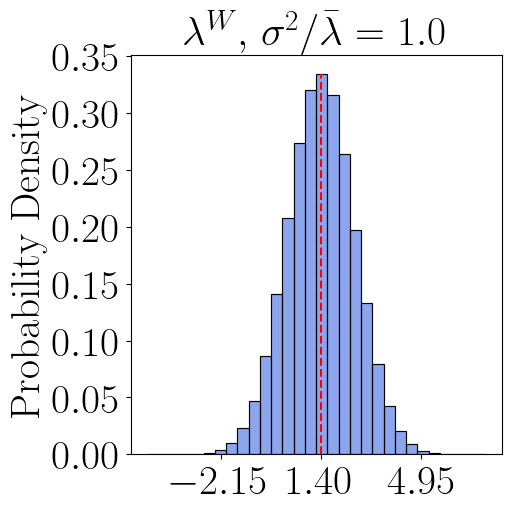

-2.1243095976805635 5.261808198934515
1.624344589440789e-05 0.5302526721216406


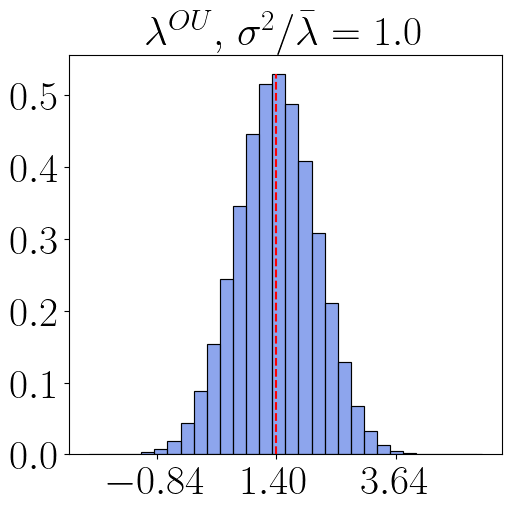

0.13592842290045312 12.765902721935426
2.849792136351545e-06 0.6793923451676337


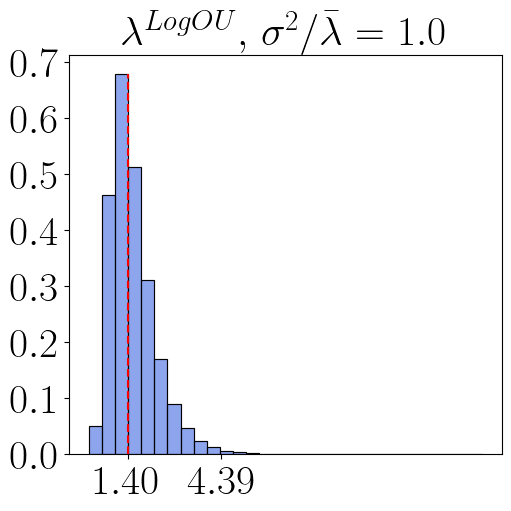

In [122]:
import seaborn as sns

def plot_data_distribution(X, title, filename):
    plt.figure(figsize=(5, 5), constrained_layout=True)
    ax = sns.histplot(X, bins=30, stat='density', kde=False, color="royalblue", edgecolor="black", alpha=0.6)

    bars = ax.patches

    # Get the min and max bin edges
    bin_edges = [bar.get_x() for bar in bars] + [bars[-1].get_x() + bars[-1].get_width()]
    min_value = min(bin_edges)
    max_value = max(bin_edges)
    print(min_value, max_value)

    densities = [bar.get_height() for bar in ax.patches]
    min_density = min(densities)
    max_density = max(densities)
    print(min_density, max_density)

    plt.xlabel('')
    plt.ylabel('')
    plt.title(title, fontsize=30)
    plt.grid(False)
    plt.vlines(lamb, 0, max_density, color='red', linestyle='--', label=r'$\bar{\lambda}$')

    std_data = np.std(X)
    if filename[0] == 'W':
        plt.xticks(np.round([1.4-3*std_data, 1.4, 1.4+3*std_data], 2), fontsize=30)
        plt.ylabel('Probability Density', fontsize=30)
    elif filename[0] == 'O':
        plt.xticks(np.round([1.4-3*std_data, 1.4, 1.4+3*std_data], 2), fontsize=30)
    else:
        plt.xticks(np.round([1.4, 1.4+4*std_data], 2), fontsize=30)

    plt.yticks(fontsize=30)

    plt.savefig(filename, dpi=150)#, bbox_inches='tight')
    plt.show()

title = r'$\lambda^{W}, \space$ $\sigma^2 / \bar{\lambda} =$' + f' ${rel_int}$'
filename = f'White_density_{rel_int}.png'
plot_data_distribution(np.concatenate(noise_white), title, filename)

title = r'$\lambda^{OU}, \space$ $\sigma^2 / \bar{\lambda} =$' + f' ${rel_int}$'
filename = f'OU_density_{rel_int}.png'
plot_data_distribution(np.concatenate(noise_OU), title, filename)

title = r'$\lambda^{LogOU}, \space$ $\sigma^2 / \bar{\lambda} =$' + f' ${rel_int}$'
filename = f'LogOU_density_{rel_int}.png'
plot_data_distribution(np.concatenate(noise_logOU), title, filename)

# Compute Empirical and theoretical variance for logOU

In [123]:
import numpy as np

def compute_empirical_variance(trajectories):
    """
    Compute the empirical variance of the lognormal OU noise across multiple trajectories.

    Parameters:
    - trajectories (list of np.ndarray): List of noise trajectories from SIS_LogOU.

    Returns:
    - empirical_variance (float): The empirical variance of the noise.
    """
    # Stack trajectories to treat them as multiple samples
    all_trajectories = np.array(trajectories)
    # Compute the variance across all trajectories
    empirical_variance = np.var(all_trajectories, axis=0).mean()  # Mean variance across all time points

    return empirical_variance


# Compute autocorrelations (using first trajectory)
var_white = compute_empirical_variance(noise_white)
var_ou = compute_empirical_variance(noise_OU)
var_logou = compute_empirical_variance(noise_logOU)

# Plot autocorrelation functions
print(f"Empirical Variance: {var_white}")
print(f"Empirical Variance OU: {var_ou}")
print(f"Empirical Variance LogOU: {var_logou}")

Empirical Variance: 1.396644640438403
Empirical Variance OU: 0.5552450507880179
Empirical Variance LogOU: 0.5572332911859353
